# Demo RAG Chat With Web and PDF
with RAG Ollama models, Selenium, and __unstructured__ by tdi@cphbusiness.dk

__RAG (Retrieval-Augmented Generation)__ is an approach of combining the classic information retrieval techniques
with modern generative technologies. It is introduced by Meta as a solution for improving the accuracy of LLM
applications by enabling them with access to new and dynamically extendable information, that exists in
external, for them, sources.<br>

In RAG, the developer can collect a set of documents, relevant to the domain, to pre-process them independently from the LLM processing, and at the next step, to integrate the RAG pre-processing outcome with the input to the LLM application.<br>

The process requires applying same models of _chunking_, _vectorisation_, and _embedding_ of the content of the external documents, as the models used forvectorisation of the prompts - the human questions in question-answering, chat, and other text generation systems.<br>

The advantages of involving RAG in the process of NLU are the enabling of personalisation and better adaptation
to the tasks, keeping consistency of the LLM by providing it with the new available facts, and therefore ensuring
higher reliability of the operations results.<br>

source: tdi@https://innotechspace.dk/holodeck/glossary-of-terms/

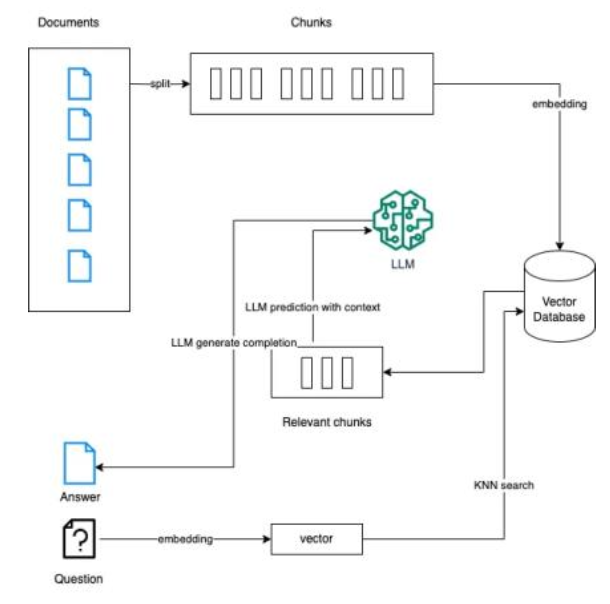

image source: https://medium.com/@kelvin.lu.au/what-we-need-to-know-before-adopting-a-vector-database-85e137570fbb

## Install Libraries

In [ ]:
#!pip install unstructured

In [ ]:
# !pip install -r ../requirements.txt

In [ ]:
# !ollama serve

In [ ]:
# !conda install poppler -y

In [ ]:
# !conda install tesseract -y

In [ ]:
!ollama list

In [ ]:
# for deployment and UI
import streamlit as st

In [ ]:
# for loading and parcing web pages
from langchain_community.document_loaders import SeleniumURLLoader

In [ ]:
# for reading and parcing multimodal pdf
from unstructured.partition.pdf import partition_pdf
from unstructured.partition.utils.constants import PartitionStrategy

In [ ]:
# for help of open-source LLMs
from langchain_ollama import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
# for text pre-processing
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore

In [ ]:
import os

## Set Environment

In [ ]:
!ollama list

In [ ]:
# !ollama pull llama3.2:3b

In [ ]:
# !ollama pull gemma3:12b

In [ ]:
embeddings = OllamaEmbeddings(model="llama3.2:3b")
vector_store = InMemoryVectorStore(embeddings)

In [ ]:
llm = OllamaLLM(model = "gemma3:12b")

## Define Functions

In [ ]:
# load page
def load_web_page(url):
    loader = SeleniumURLLoader(urls=[url])
    documents = loader.load()
    return documents

In [ ]:
# parse the page text
def split_web_text(docs):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        add_start_index=True
    )
    data = text_splitter.split_documents(docs)
    return data


In [ ]:
# load pdf
def upload_pdf(file):
    with open(pdfs_directory + file.name, "wb") as f:
        f.write(file.getbuffer())

In [43]:
# extend llm with images
def text_from_image(file_path):
    print(file_path)
    model_with_image_context = llm.bind(images=[file_path])
    return model_with_image_context.invoke("Tell me what do you see in this picture.")

In [ ]:
# parse pdf content
def parse_pdf(file_path, media):
    # settings
    elements = partition_pdf(
        file_path,
        strategy=PartitionStrategy.HI_RES,
        extract_image_block_types=["Image", "Table"],
        extract_image_block_output_dir=media
    )

    # extract the pdf text
    text_elements = [element.text for element in elements if element.category not in ["Image", "Table"]]
    print(text_elements)
    
    # extract the text from the images in the pdf document
    for file_path in os.listdir(media):
        fname, extension = os.path.splitext(file_path)
        if extension == 'jpg':
            image_text = text_from_image(media + file)
            text_elements.append(image_text)

    return "\n\n".join(text_elements)

In [ ]:
def split_pdf_text(text):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        add_start_index=True
    )

    return text_splitter.split_text(text)

In [ ]:
def store_web_docs(docs):
    vector_store.add_documents(docs)
    return

In [ ]:
def store_pdf_docs(texts):
    vector_store.add_texts(texts)
    return

In [ ]:
def retrieve_docs(query):
    return vector_store.similarity_search(query)

In [ ]:
def answer_question(question, documents):
    context = "\n\n".join([doc.page_content for doc in documents])
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm
    return chain.invoke({"question": question, "context": context})

In [ ]:
# A template for the dialoque
template = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
"""

## Test

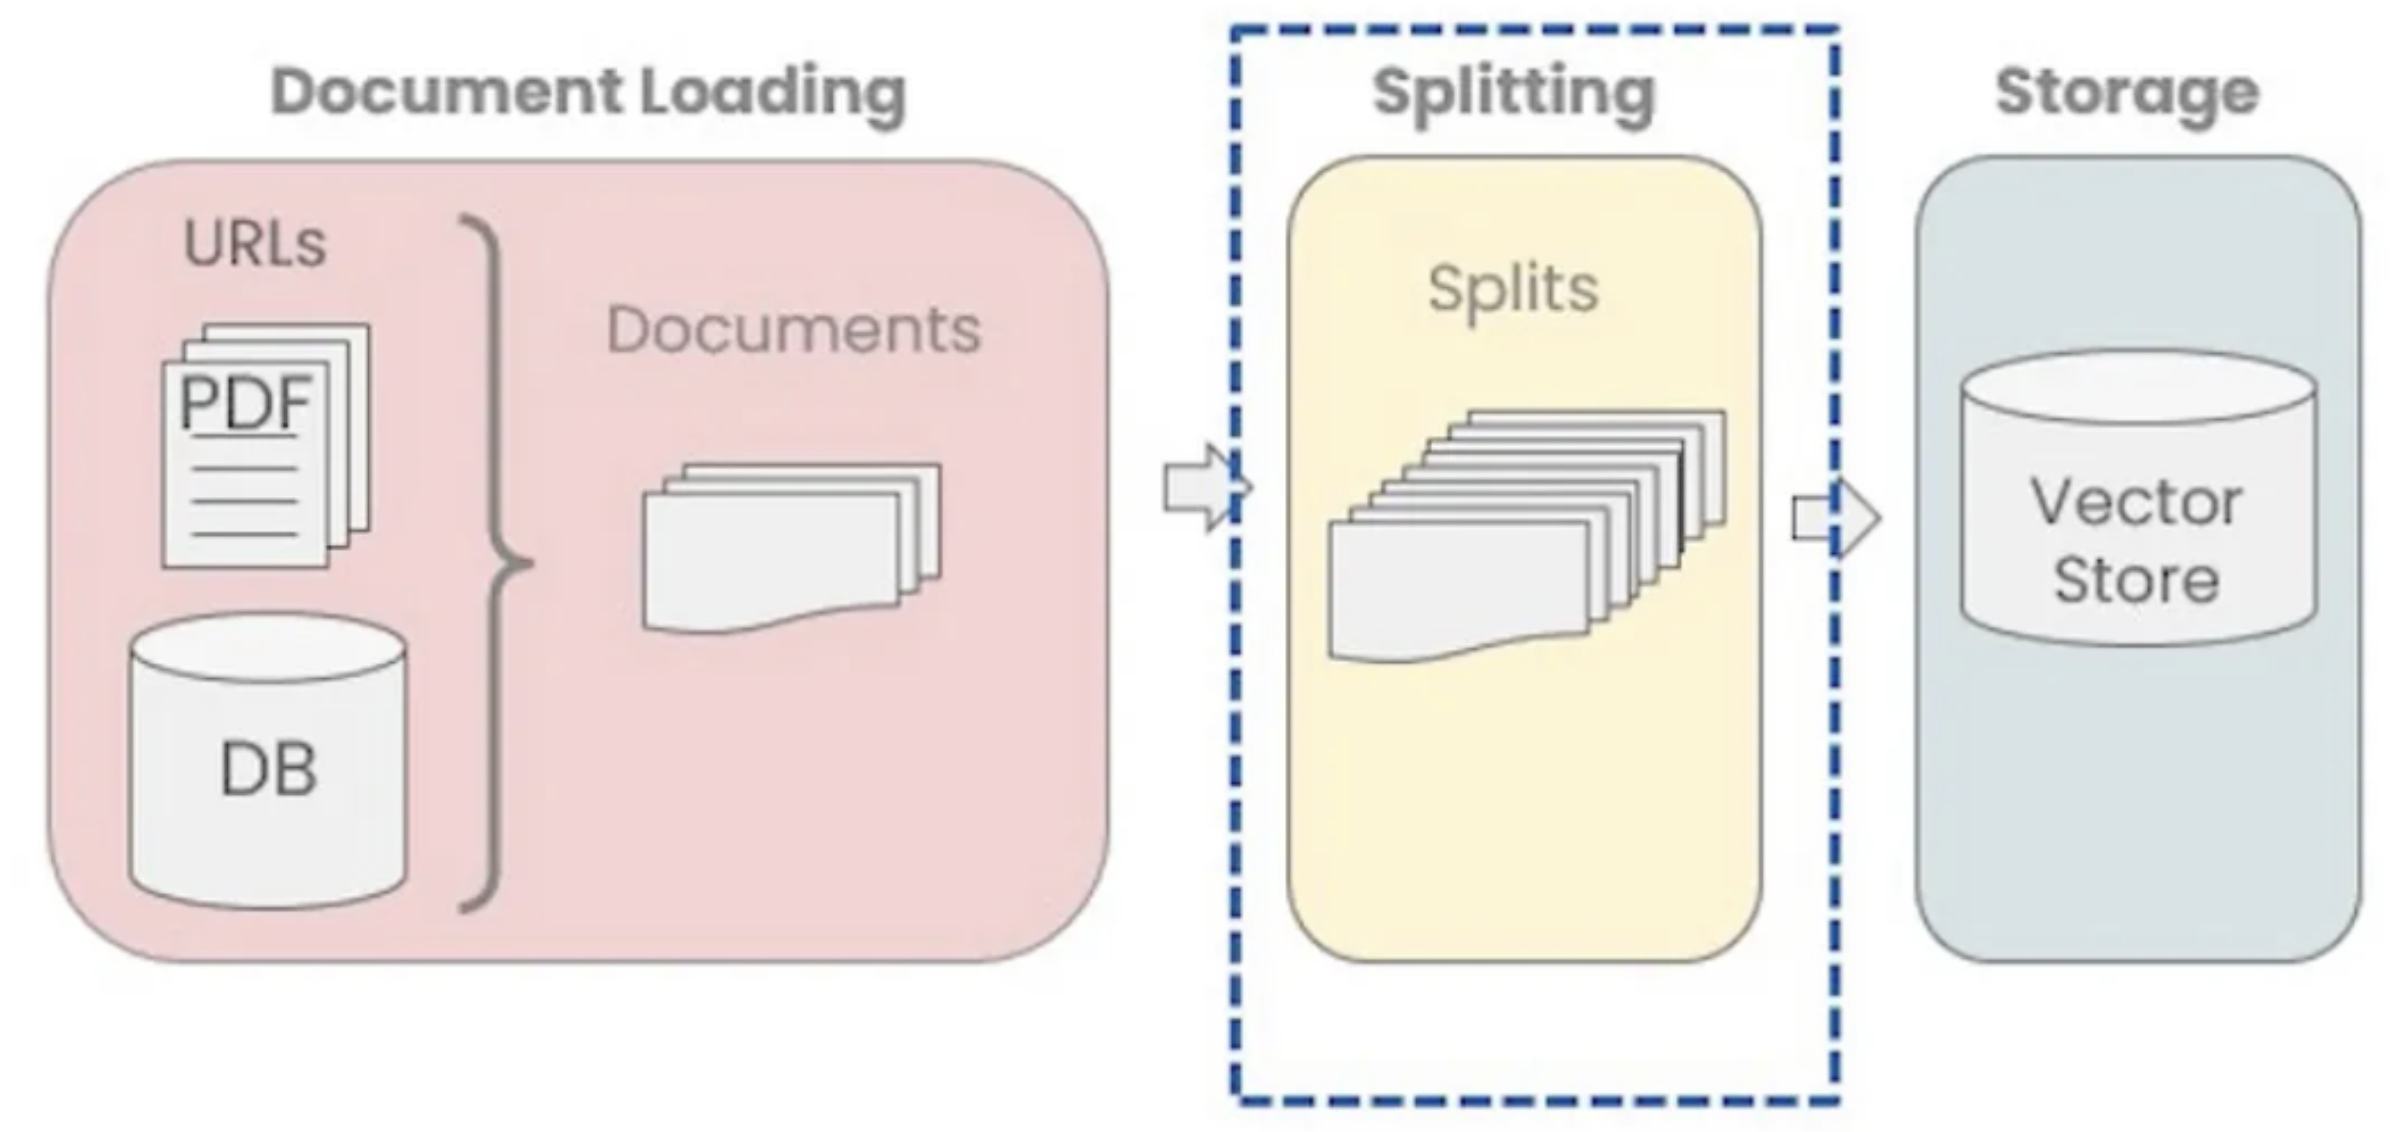

### Read Web

In [ ]:
url = 'https://docs.streamlit.io/develop/api-reference'

In [ ]:
# read a web page
doc = load_web_page(url)

In [ ]:
# split the text in chunks
text = split_web_text(doc)

In [ ]:
# embed the chunks and store them in vector db
store_web_docs(text)

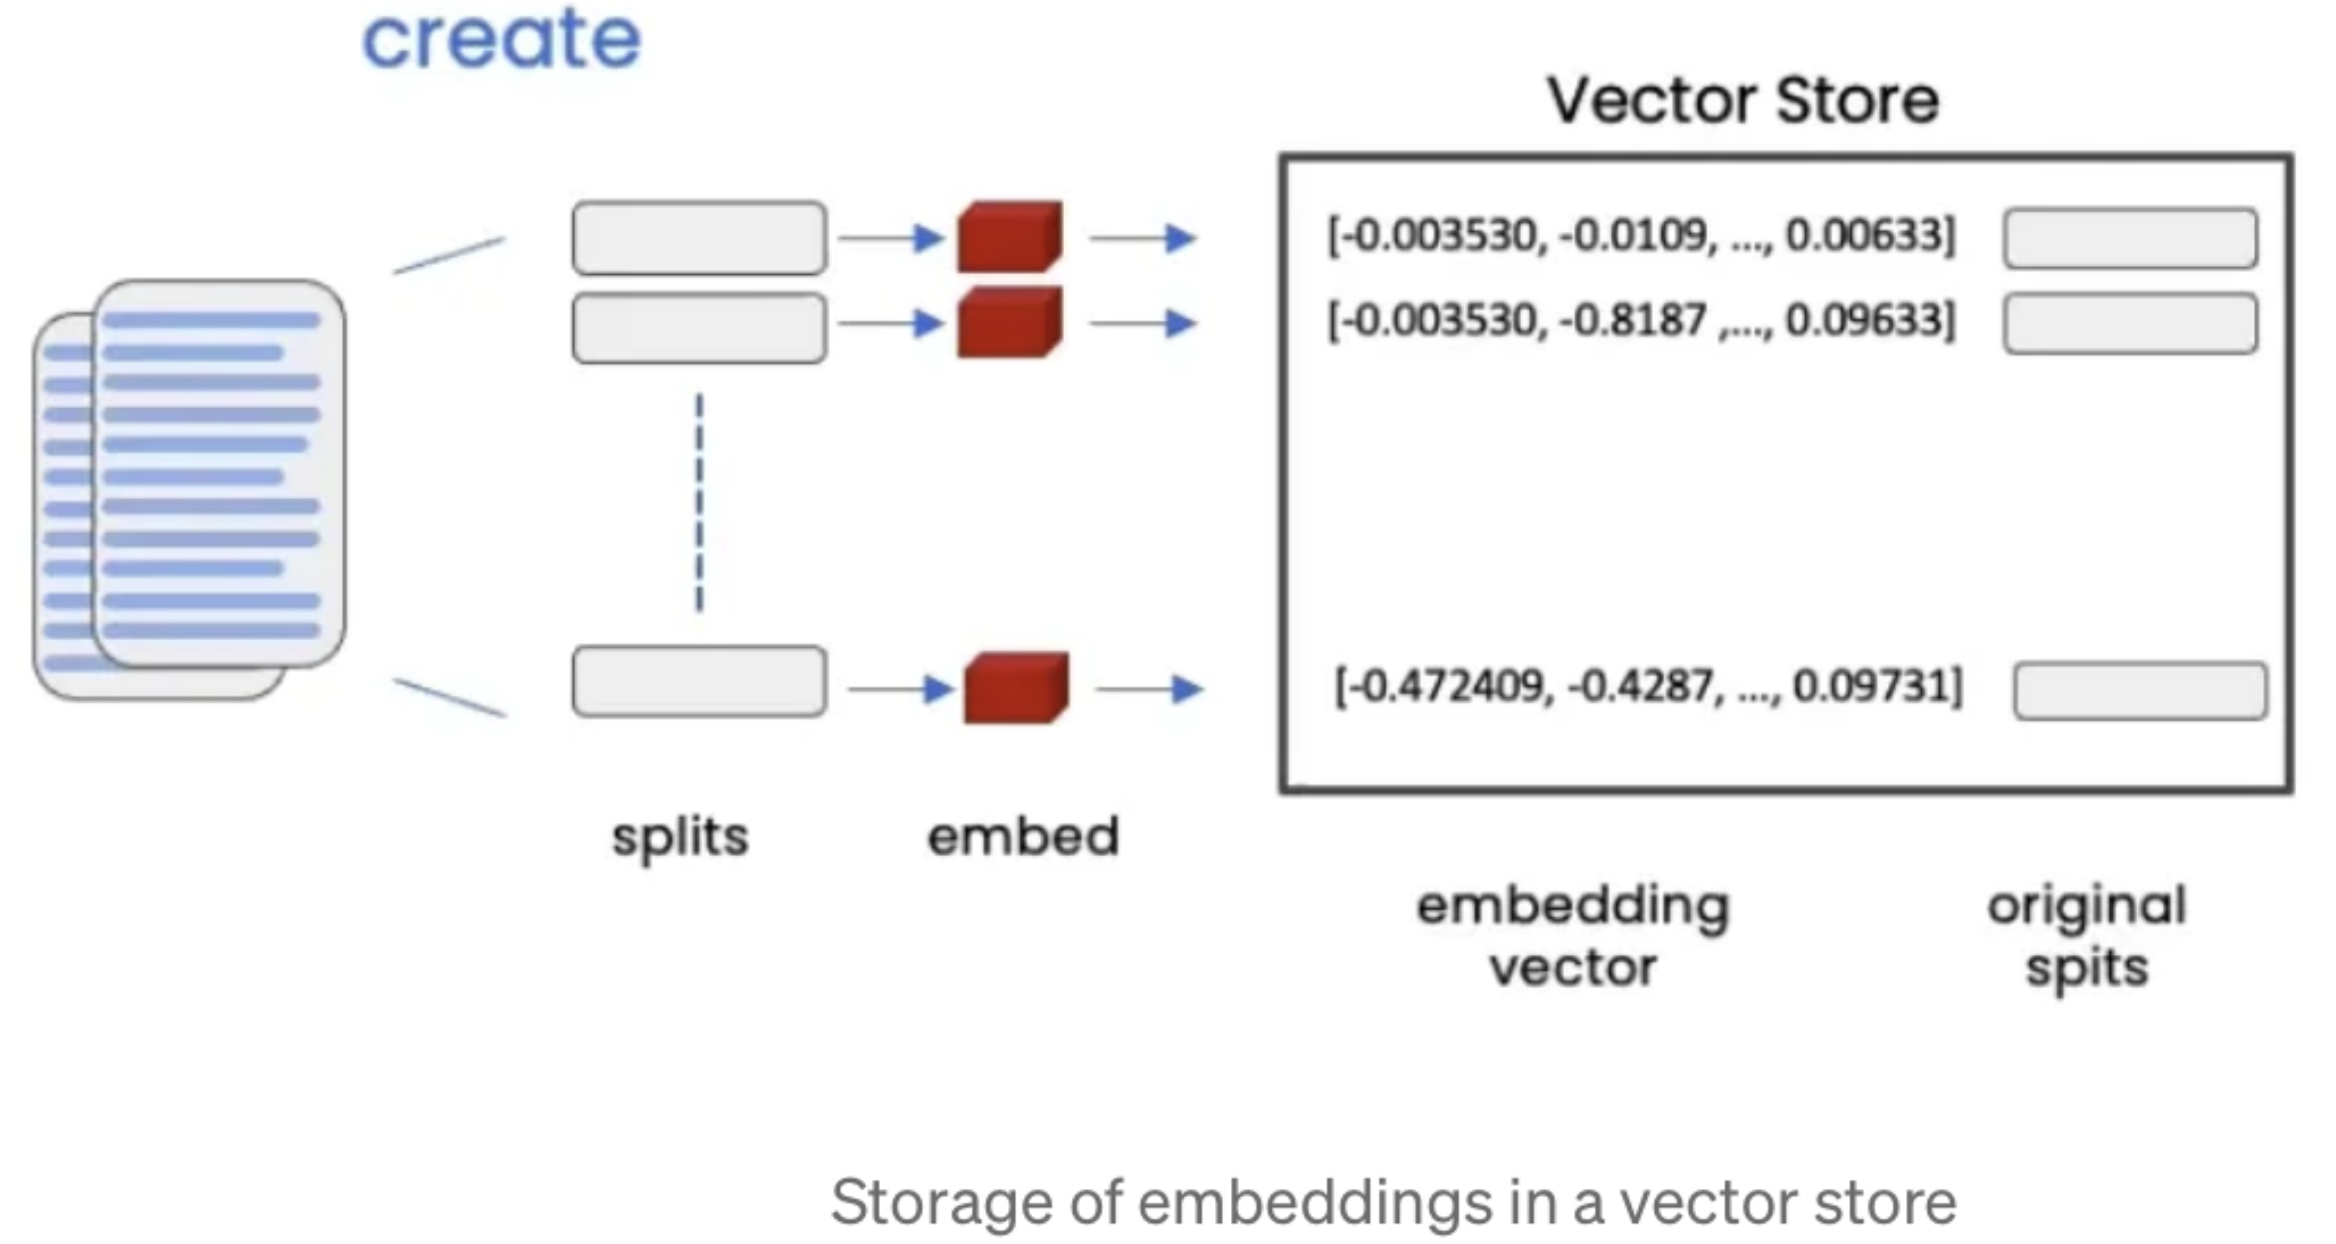

In [ ]:
question = 'How to create menu in Streamlit?'

In [ ]:
# send the user's question to the vector db for retrieving relevant context
retrieved = retrieve_docs(question)

In [ ]:
retrieved

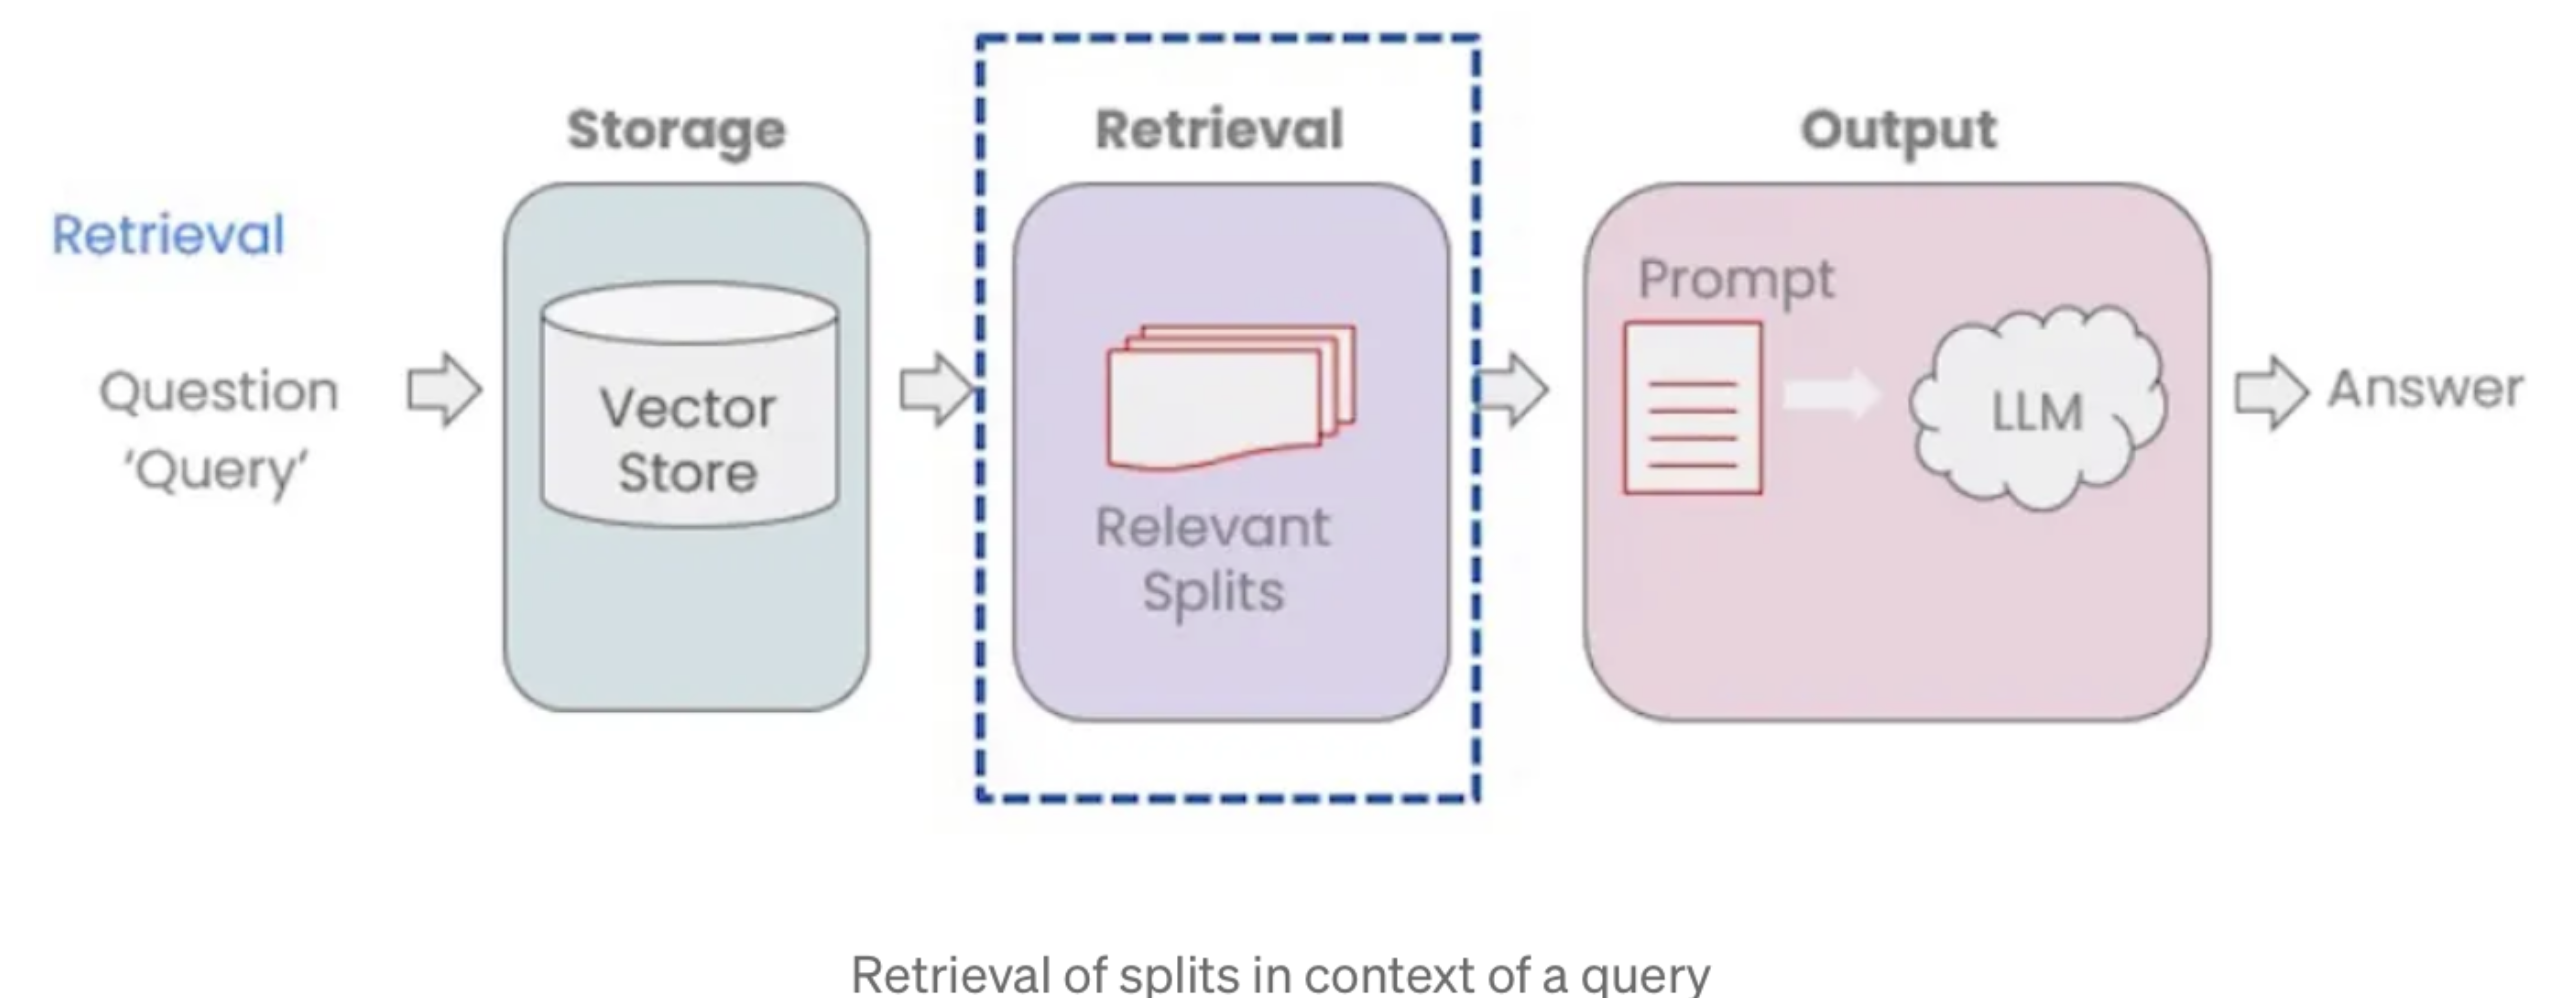

In [ ]:
answer = answer_question(question, retrieved)

In [ ]:
answer

### Read PDF

In [ ]:
# directories
data = '../data/'
media = '../media/'

In [ ]:
file = "rag.pdf"

In [ ]:
file_path = os.path.join(data, file)
print(file_path)

In [ ]:
text = parse_pdf(file_path, media)

In [ ]:
text = split_pdf_text(text)

In [ ]:
store_pdf_docs(text)

In [ ]:
question = "How does Data Science Holodeck project apply RAG?"

In [ ]:
question = "What is LLM used for?"

In [ ]:
related_documents = retrieve_docs(question)  

In [ ]:
answer = answer_question(question, related_documents)

In [ ]:
answer